In [9]:
import numpy as np
import dolfin as fin
import matplotlib.pyplot as plt
from mud.examples.fenics import fenics_poisson_solve, run_fenics

__author__ = "Carlos del-Castillo-Negrete"
__copyright__ = "Carlos del-Castillo-Negrete"
__license__ = "mit"

# Matplotlib plotting options
plt.backend = "Agg"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.size"] = 16
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{bm}"
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts}"

In [2]:
fin.set_log_level(50)
_logger = logging.getLogger(__name__)


def piecewise_eval_from_vector(u, d=1):
    """
    Takes an iterable `u` with y-values (on interior of equispaced unit domain)
    and returns the string for an expression
    based on evaluating a piecewise-linear approximation through these points.
    """
    n = len(u)
    dx = 1 / (n + 1)
    xvals = [i * dx for i in range(n + 2)]
    yvals = [0] + list(u) + [1]

    s = ""
    for i in range(1, len(xvals)):
        start = xvals[i - 1]
        end = xvals[i]
        diff = start - end
        s += f" ((x[{d}] >= {start}) && (x[{d}] < {end}))*"
        s += f"({yvals[i-1]}*((x[{d}]-{end})/{diff}) + (1 - ((x[{d}]-{end})/{diff}))*{yvals[i]} ) +"

    return s[1:-1]


def fenics_poisson_solve(gamma=-3, lam=None):
    # Define mesh
    mesh = fin.UnitSquareMesh(36, 36)

    # Initialize mesh function for interior domains
    domains = fin.MeshFunction("size_t", mesh, mesh.topology().dim())
    domains.set_all(0)

    # Initialize mesh function for boundary domains
    boundaries = fin.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
    boundaries.set_all(0)

    # Create classes for defining parts of the boundaries and the interior
    # of the domain
    class Left(fin.SubDomain):
        def inside(self, x, on_boundary):
            return fin.near(x[0], 0.0)

    class Right(fin.SubDomain):
        def inside(self, x, on_boundary):
            return fin.near(x[0], 1.0)

    class Bottom(fin.SubDomain):
        def inside(self, x, on_boundary):
            return fin.near(x[1], 0.0)

    class Top(fin.SubDomain):
        def inside(self, x, on_boundary):
            return fin.near(x[1], 1.0)

    # Initialize sub-domain instances
    left = Left()
    top = Top()
    right = Right()
    bottom = Bottom()
    left.mark(boundaries, 1)
    top.mark(boundaries, 2)
    right.mark(boundaries, 3)
    bottom.mark(boundaries, 4)

    if lam is None:
        cons = gamma * 823543 / 12500
        g_L = fin.Expression(f"pow(x[1], 2) * pow(1 - x[1], 5) * {cons}", degree=3)
    else:
        g_L = fin.Expression(piecewise_eval_from_vector(lam), degree=2)

    g_R = fin.Constant(0.0)
    f = fin.Expression(
        "10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", degree=2
    )

    # Define function space and basis functions
    V = fin.FunctionSpace(mesh, "Lagrange", 1)
    u = fin.TrialFunction(V)
    v = fin.TestFunction(V)

    # Define Dirichlet boundary (x = 0 or x = 1)
    def top_bottom_boundary(x):
        return x[1] < fin.DOLFIN_EPS or x[1] > 1.0 - fin.DOLFIN_EPS

    dirichlet_bc = fin.Constant(0.0)  # top and bottom
    bcs = fin.DirichletBC(
        V, dirichlet_bc, top_bottom_boundary
    )  # this is required for correct solutions

    # Define new measures associated with the interior domains and
    # exterior boundaries
    dx = fin.Measure("dx", domain=mesh, subdomain_data=domains)
    ds = fin.Measure("ds", domain=mesh, subdomain_data=boundaries)

    # Define variational form
    a0 = fin.Constant(1.0)
    F = (
        fin.inner(a0 * fin.grad(u), fin.grad(v)) * dx(0)
        - g_L * v * ds(1)
        - g_R * v * ds(3)
        - f * v * dx(0)
        - f * v * dx(1)
    )

    # Separate left and right hand sides of equation
    a, L = fin.lhs(F), fin.rhs(F)

    # Solve problem
    u = fin.Function(V)
    fin.solve(a == L, u, bcs)

    return u


def run_samples(
    num_samples=10,
    num_sensors=20,
    mins=[-4, -4],
    maxs=[0, 0],
    sensor_low=[0, 0],
    sensor_high=[1, 1],
    gamma=-3,
    save_data=True,
):

    if len(mins) != len(maxs):
        raise ValueError("min/max arrays must be of same length")

    sensors = np.random.uniform(low=sensor_low, high=sensor_high, size=(num_sensors, 2))
    lams = np.random.uniform(low=mins, high=maxs, size=(num_samples, len(mins)))
    data = np.zeros((num_samples, num_sensors))
    true_vals = np.zeros((num_sensors, 1))

    for i in tqdm(range(len(lams))):
        u = fenics_poisson_solve(lam=lams[i])
        for j, s in enumerate(sensors):
            data[i, j] = u(s)

    # Solve true solution
    u_true = fenics_poisson_solve(gamma=gamma)
    for j, s in enumerate(sensors):
        true_vals[j] = u_true(s)

    # Store coordinates and grid where true solution solved for plotting later
    c = u_true.function_space().mesh().coordinates()
    v = np.array([u_true(c[i, 0], c[i, 1]) for i in range(len(c))])

    full_res = {
        "lam": lams,
        "data": data,
        "true_vals": true_vals,
        "domain": list(zip(mins, maxs)),
        "sensors": sensors,
        "u": (c, v),
    }

    ts = datetime.now().strftime("%Y_%m_%d-%I:%M:%S_%p")
    if save_data:
        with open(f"s{num_samples}_n{num_sensors}_d{len(mins)}_res-{ts}", "wb") as fp:
            pickle.dump(full_res, fp)

    return full_res

NameError: name 'fin' is not defined

## Functions for solving Inverse Problem

## Notebooks Settings

- Matplotlib widget: for manipulating images interactively 
- Figure dictionary: storing which figures have been opened

In [2]:
%matplotlib widget
figs = {}

# Poisson Problem

Define boundary conditions.

- Dirichlet on the upper and lower boundaries. 
- Neumann boundary on right

## True Solution

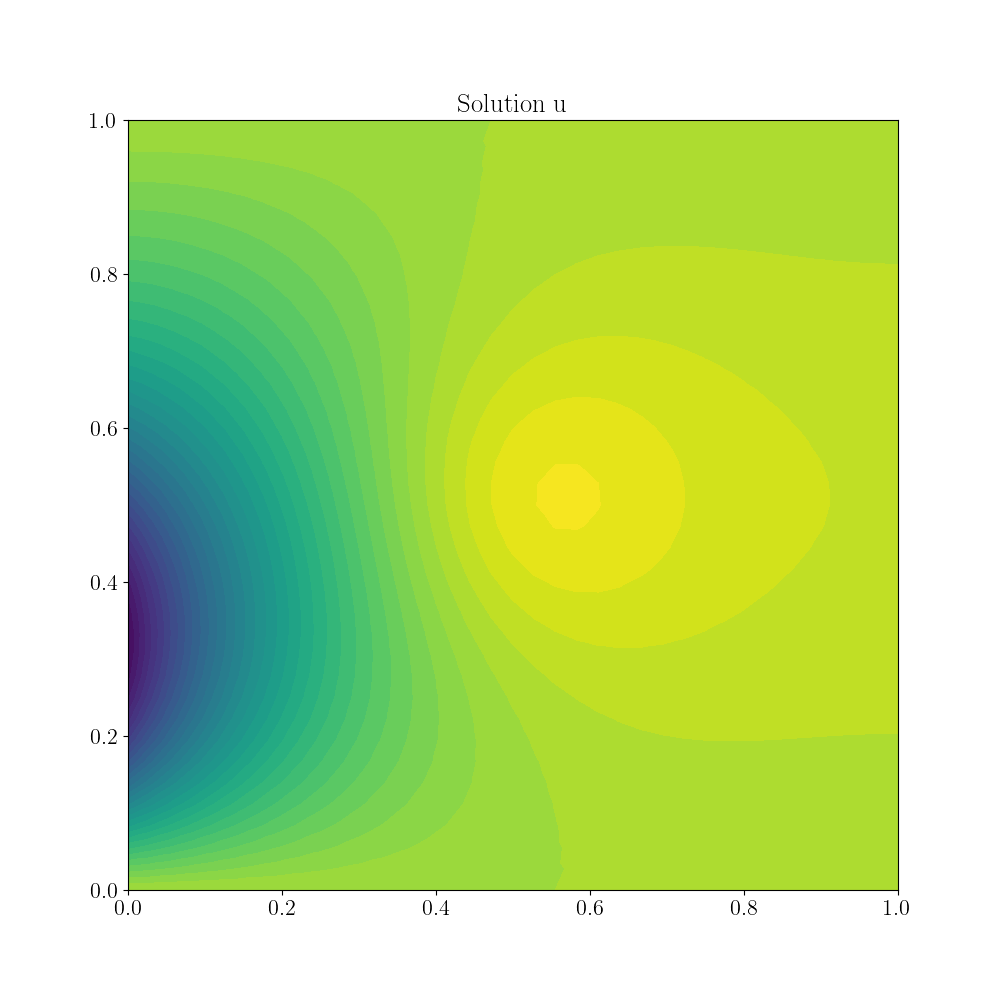

In [5]:
u_true = fenics_poisson_solve(gamma=-3)

# Plot solution
plt.figure()
fin.plot(u_true, title="Solution u")

# Show plots
plt.show()

## Using a Linear Spline Approximation to $g_L$

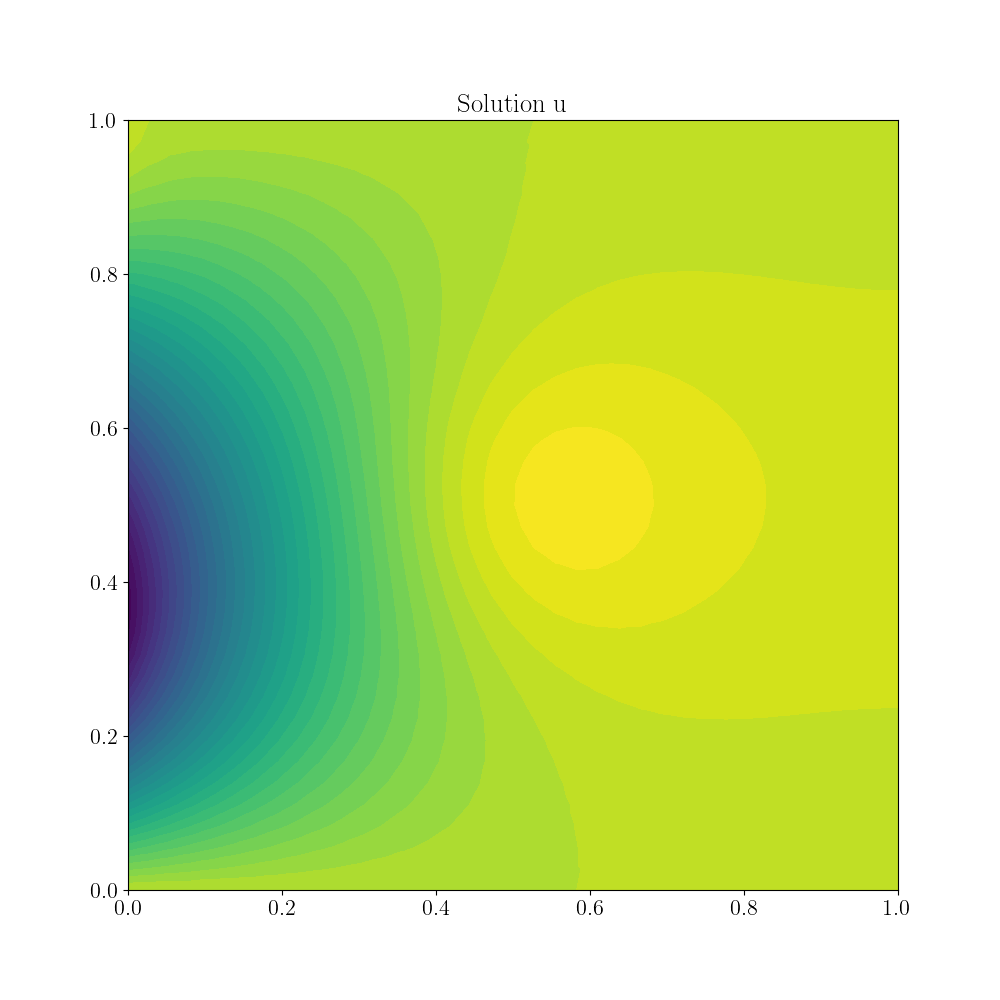

In [7]:
u_approx = fenics_poisson_solve(lam=[-3, -1])

# Plot solution
plt.figure()
fin.plot(u_approx, title="Solution u")

# Show plots
plt.show()

## Comparison

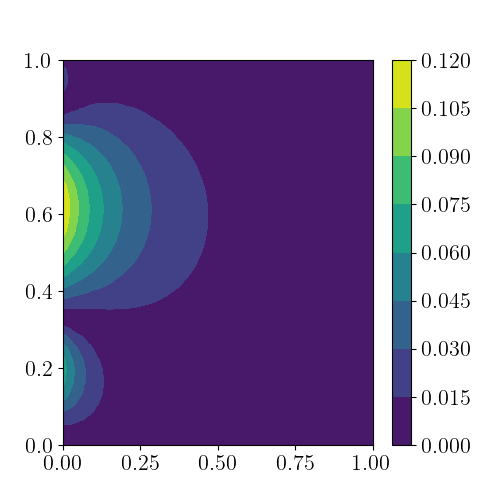

In [10]:
c = u_true.function_space().mesh().coordinates()
v = np.array(
    [
        np.abs(u_true(c[i, 0], c[i, 1]) - u_approx(c[i, 0], c[i, 1]))
        for i in range(len(c))
    ]
)

fig = plt.figure(figsize=(5, 5))
tcf = plt.tricontourf(c[:, 0], c[:, 1], v)

fig.colorbar(tcf)

# Run trials

## Two dim

### Creating Dataset

In [ ]:
mins = [-4, -4]
maxs = [0, 0]
res_2d = run_samples(num_samples=1000, num_sensors=100, mins=mins, maxs=maxs)

### Loading Dataset

In [7]:
with open("s1000_n100_d2", "rb") as df:
    res_2d = pickle.load(df)

## Four dim

### Creating Data-Set

Takes about 45 mins for 1000 samples x 100 sensors.

In [ ]:
mins = [-4, -4, -4, -4]
maxs = [0, 0, 0, 0]
res_4d = run_samples(num_samples=1000, num_sensors=100, mins=mins, maxs=maxs)

In [17]:
with open("s1000_n100_d4-v2", "rb") as fp:
    ds = pickle.load(fp)
ds["u"]

(array([[0.        , 0.        ],
        [0.02777778, 0.        ],
        [0.05555556, 0.        ],
        ...,
        [0.94444444, 1.        ],
        [0.97222222, 1.        ],
        [1.        , 1.        ]]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [18]:
full_res = {
    "lam": ds["lam"],
    "data": ds["data"],
    "true_vals": tv["true_vals"],
    "domain": ds["domain"],
    "sensors": ds["sensors"],
    "u": ds["u"],
}

In [19]:
with open("s1000_n100_d4-v3", "wb") as fp:
    pickle.dump(full_res, fp)
ds["u"]

(array([[0.        , 0.        ],
        [0.02777778, 0.        ],
        [0.05555556, 0.        ],
        ...,
        [0.94444444, 1.        ],
        [0.97222222, 1.        ],
        [1.        , 1.        ]]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [13]:
with open("lam_4d_res_tv", "rb") as fp:
    tv = pickle.load(fp)
tv["true_vals"].shape

(100, 1)

### Loading Data-Set

In [29]:
df = "s1000_n100_d4_res-2022_08_02-03_00_52_PM"

In [30]:
raw_data, poisson_prob = load_poisson_prob(df, std_dev=0.05, seed=11)

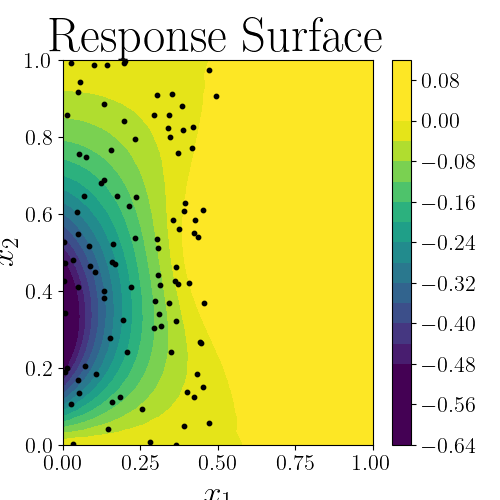

In [31]:
figs = poisson_solution_surface(raw_data, figsize=(9, 9), figs=figs)

ValueError: operands could not be broadcast together with shapes (9801,2) (4,) 

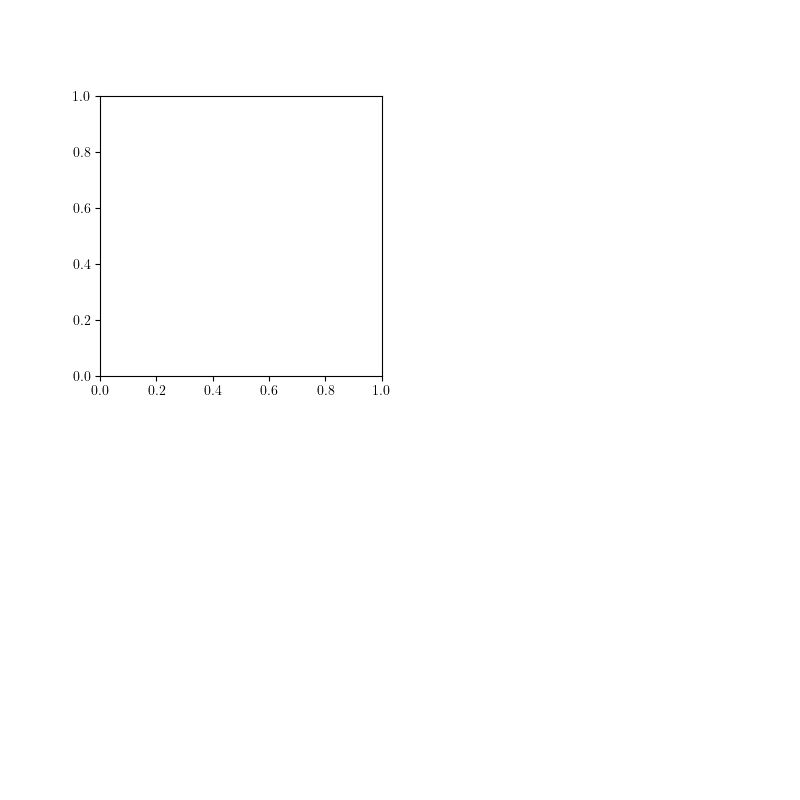

In [19]:
figs = poisson_pca_solution(poisson_prob, figs=figs)